# Preamble

In [7]:
import numpy as np
import autograd.numpy as npa
import matplotlib.pylab as plt
import argparse
import os
import json

import sys
sys.path.append('../ceviche')

from ceviche import fdfd_ez as fdfd
from ceviche import fdtd, jacobian
from ceviche.constants import *
from ceviche.utils import imarr, aniplot, my_fft

# note, need angler package for mode profile calculation (pip install angler) https://github.com/fancompute/angler
from angler import Simulation

""" Forward Mode Demo.  This file generates Fig. 4 of the main text.
    It computes the coupling efficiency of a grating coupler and differentiates the spectrum with respect to the grating fill factor
"""

%matplotlib inline

# set parameters

In [8]:
# """ PARSE ARGUMENTS """

# # # to run with plots, run `python examples/grating_coupler.py --plot`
# parser = argparse.ArgumentParser(description='Process those args!')
# parser.add_argument('--plot', dest='plot_all', default=False, action='store_true', help='plot everything')
# args = parser.parse_args()
# plot_all = args.plot_all

plot_all = True

if plot_all:
    print('plotting everything...')

plotting everything...


In [9]:
# """ DEFINE PARAMETERS """
npml = 10                          # number of grid points in PML
dl = 10e-8                          # size (m) of each grid cell
ff = 0.5                           # grating teeth fill factor
lambda0 = 1550e-9
omega0 = 2 * np.pi * C_0 / lambda0
k0 = 2 * np.pi / lambda0

neff_teeth = 2.846                 # effective index of slab with 'teeth' thickness
neff_hole = 2.534                  # effective index of slab with 'hole' thickness

theta_deg = 20                     # angle of incidence of line source
theta = theta_deg / 360 * 2 * np.pi

spc = 1.5e-6                       # spacing  (m) between PML and {top source, bottom substrate, left grating teeth, right modal source} (m)
h0 = 220e-9                        # thickness (m) of grating where teeth are
h1 = 150e-9                        # thickness (m) of grating where there is a hole
subs = 1.5e-6                        # thickness (m) of top and bottom substrate
num_teeth = 7                     # number of grating teeth

sigma = 40e-15                     # pulse duration (s)
total_time = 1.9e-12               # total simulation time (s)
t0 = sigma * 7                     # delay (s) of pulse center from t=0

sub_index = 1.44                   # index of SiO2 at 1.55 um
grating_index = 3.48               # index of (amorphous) Si at 1.55 um
sub_eps = sub_index ** 2
grating_eps = grating_index ** 2

# effective index of grating (with teeth)
neff = ff * neff_teeth + (1 - ff) * neff_hole
print('-> effective index of {}'.format(neff))

# compute grating period (Lambda) and total length of grating (w) based on matching wavevectors of waveguide mode in grating to free space
Lambda = lambda0 / (neff - np.sin(theta))
w = Lambda * num_teeth
print('-> grating period of {} nanometers'.format(Lambda / 1e-9))

NPML = [npml, npml]

# compute the grid size of the domain given these parameters
Nx = npml + int((spc + w + 2 * spc) / dl) + npml                    # left to right (along grating direction)
Ny = npml + int((2 * spc + subs + h0 + subs + spc) / dl) + npml     # top to bottom (perpendicular to grating)
print('-> dimensions of {} x {}'.format(Nx, Ny))


-> effective index of 2.69
-> grating period of 660.1419495120429 nanometers
-> dimensions of 111 x 97


In [10]:
# """ DEFINE PERMITTIVITY """

# relative permittivity array
eps_r = np.ones((Nx, Ny))

# define substrate
eps_r[:, npml + int(spc / dl) : npml + int((spc + 2 * subs + h0) / dl)] = sub_eps

# define grating base
eps_r[:, npml + int((spc + subs) / dl) : npml + int((spc + subs + h1) / dl)] = grating_eps
eps_base = eps_r.copy()  # make a copy of permittivity without teeth

# define grating teeth
print('-> {} grating teeth within length of {} microns'.format(num_teeth, w / 1e-6))
for i in range(num_teeth):
    tooth_begin = npml + int(spc / dl) + (i + 1) * int(Lambda / dl)
    tooth_end = tooth_begin + int((ff * Lambda) / dl)
    eps_r[tooth_begin:tooth_end, npml + int((spc + subs + h1) / dl) : npml + int((spc + subs + h0) / dl)] = grating_eps


-> 7 grating teeth within length of 4.620993646584301 microns


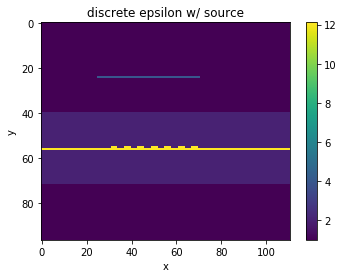

In [11]:
# """ DEFINE SOURCE """

# stores the line source
source = np.zeros((Nx, Ny), dtype=np.complex128)

# x-indices of each grid cell in line source
x_grids = np.arange(npml + int(spc / dl), npml + int((spc + w) / dl))

# compute the phase along the line source to get angle theta
ky = k0 * np.sin(theta)
source_vals = np.exp(-1j * ky * dl * x_grids)
source[x_grids, -npml - int(spc / dl)] = source_vals

# get the source power for normalization
source_p = np.sum(np.square(np.abs(source)))

# plot the starting permittivity, along with the source
if plot_all:
    plt.imshow(np.real(imarr(eps_r + 3 * np.abs(source))))
    plt.colorbar()
    plt.title('discrete epsilon w/ source')
    plt.xlabel('x'); plt.ylabel('y')
    plt.show()



### DO AN FDFD RUN TO INSPECT FIELDS

-> solving FDFD for discrete permittivity


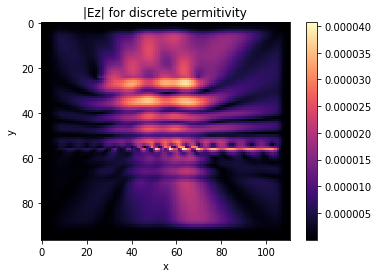

In [12]:
#

if plot_all:
    print('-> solving FDFD for discrete permittivity')
    F = fdfd(omega0, dl, eps_r, NPML)
    Hx, Hy, Ez = F.solve(source)
    plt.imshow(np.abs(imarr(Ez)), cmap='magma')
    plt.title('|Ez| for discrete permitivity')
    plt.xlabel('x'); plt.ylabel('y')
    plt.colorbar()
    plt.show()

### MAKE A CONITNOUS EPSILON FOR PROJECTION

-> solving FDFD for continuous epsilon


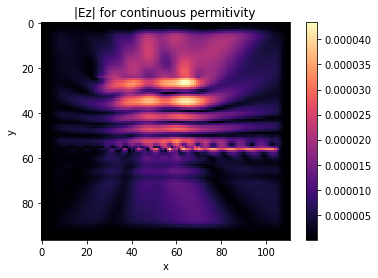

In [13]:
#
# note: the idea here is to define a _continuous_ grating using smooth projections
#       this way, we can smoothly differentiate through to parameters like the fill factor

# define grating teeth before projection
teeth_density = np.zeros((Nx, Ny))
density_arr = np.square(np.sin(2 * np.pi * dl * x_grids / Lambda / 2))
teeth_density[x_grids, npml + int((spc + subs + h1) / dl) : npml + int((spc + subs + h0) / dl)] = density_arr[:, np.newaxis]

def sigmoid(x, strength=1):
    # smooth projection from {-inf, inf} to {0, 1}
    return 1 / (npa.exp(-strength * x) + 1)

def projection(density, center, eps_min, eps_max, strength=15):
    """ Project array 'density' using a center value of 'center' into a permittivity within {0, eps_max - eps_max} 
         Note: we use this projection to add to eps_base later.
    """
    sig_dens = sigmoid(density - center, strength=strength)
    eps = (eps_max - eps_min) * sig_dens
    return eps

# project the teeth density, using the fill factor as the center value.
# when ff is high, this will make 'fatter' gratings in the projection
eps_teeth_proj = projection(teeth_density, (1 - ff), sub_eps, grating_eps)
eps_total = eps_teeth_proj + eps_base

# plot the FDFD simulation results for this continuous version of the permittiviy
if plot_all:
    print('-> solving FDFD for continuous epsilon')
    F = fdfd(omega0, dl, eps_total, NPML)
    Hx, Hy, Ez = F.solve(source)
    plt.imshow(np.abs(imarr(Ez)), cmap='magma')
    plt.title('|Ez| for continuous permitivity')
    plt.xlabel('x'); plt.ylabel('y')
    plt.colorbar()
    plt.show()



### DEFINE MODAL SOURCE / PROBE 


-> setting up modal source


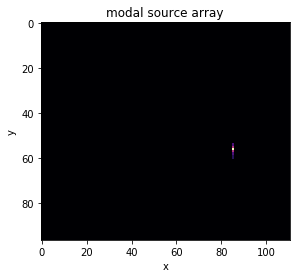

In [14]:
#
print('-> setting up modal source')

# make an angler simulation with the starting permittivity, to compute the modal source
sim = Simulation(omega0, eps_base, dl, [npml, npml], pol='Ez', L0=1)
center_y = npml + int((spc + subs + h1 / 2) / dl)
sim.add_mode(neff_hole, 'x', center=[npml + int(spc / dl), center_y], width=int(5 * h1 / dl), scale=1, order=1)
sim.setup_modes()

# get the wg mode profile as an array
wg_mode = np.flipud(np.abs(sim.src.copy())).reshape((Nx, Ny, 1))

# compute the power in the waveguide mode for normalization
wg_mode_p = np.sum(np.square(np.abs(wg_mode)))

# plot the wavegiude mode source array
if plot_all:
    plt.imshow(np.real(imarr(wg_mode)), cmap='magma')
    plt.title('modal source array')
    plt.xlabel('x'); plt.ylabel('y')
    plt.show()

### DEFINE TIME DOMAIN PROBLEM

-> total of 19731 time steps
-> measuring spectral power in for base waveguide
   - done with time step 0 of 19731 (0%)
   - done with time step 1000 of 19731 (5%)
   - done with time step 2000 of 19731 (10%)
   - done with time step 3000 of 19731 (15%)
   - done with time step 4000 of 19731 (20%)
   - done with time step 5000 of 19731 (25%)
   - done with time step 6000 of 19731 (30%)
   - done with time step 7000 of 19731 (35%)
   - done with time step 8000 of 19731 (40%)
   - done with time step 9000 of 19731 (45%)
   - done with time step 10000 of 19731 (50%)
   - done with time step 11000 of 19731 (55%)
   - done with time step 12000 of 19731 (60%)
   - done with time step 13000 of 19731 (65%)
   - done with time step 14000 of 19731 (70%)
   - done with time step 15000 of 19731 (76%)
   - done with time step 16000 of 19731 (81%)
   - done with time step 17000 of 19731 (86%)
   - done with time step 18000 of 19731 (91%)
   - done with time step 19000 of 19731 (96%)
-> computing FFT

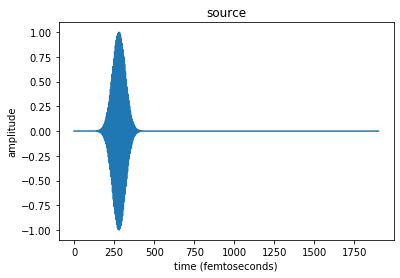

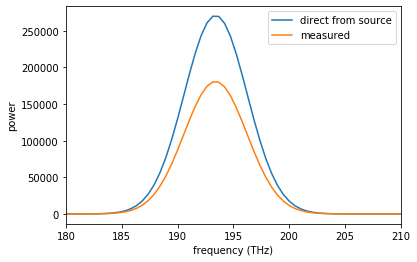

In [15]:
#
# reshape things for the FDTD
eps_total = eps_total.reshape((Nx, Ny, 1))
source = source.reshape((Nx, Ny, 1))

# make an FDTD and get its time step
F_t = fdtd(eps_total, dl, [npml, npml, 0])
dt = F_t.dt
steps = int(total_time / dt)
times = np.arange(steps)
print('-> total of {} time steps'.format(steps))

# make a gaussian source
gaussian = lambda t: np.exp(-(t - t0 / dt)**2 / 2 / (sigma / dt)**2) * np.cos(omega0 * t * dt)
source_fn = lambda t: np.abs(wg_mode) * gaussian(t)
spect_in = np.square(np.abs(my_fft(gaussian(times))))
delta_f = 1 / steps / dt
freq_x = np.arange(steps) * delta_f

# compute normalization power spectrum
F_norm = fdtd(eps_base.reshape((Nx, Ny, 1)), dl, [npml, npml, 0])
measured = []
print('-> measuring spectral power in for base waveguide')
for t_index in range(steps):
    if t_index % 1000 == 0:
        print('   - done with time step {} of {} ({}%)'.format(t_index, steps, int(t_index / steps * 100)))
    fields = F_norm.forward(Jz=source_fn(t_index))
    measured.append(npa.sum(fields['Ez'] * np.flipud(wg_mode)))

# get spectral power
print('-> computing FFT')
measured_f = my_fft(npa.array(measured))
spect_in_measure = npa.square(npa.abs(measured_f)) / wg_mode_p   # this is to normalize by the straight waveguide mode power

# plot the source amplitude in the time domain
if plot_all:
    plt.plot(times * F_t.dt / 1e-15, gaussian(times))
    plt.title('source')
    plt.xlabel('time (femtoseconds)')
    plt.ylabel('amplitude')
    plt.show()

# plot the source power in the frequency domain
if plot_all:
    plt.plot(freq_x / 1e12, spect_in, label='direct from source')
    plt.plot(freq_x / 1e12, spect_in_measure, label='measured')
    plt.xlabel('frequency (THz)')
    plt.ylabel('power')
    plt.xlim((180, 210))
    plt.legend()
    plt.show()

if plot_all:
    if False: # takes an FDTD simulation to generate.
              # Make true if you want to see `num_panels` field plots at even intervals
        aniplot(F_t, source_fn, steps, component='Ez', num_panels=5)


working on axis 0/5 for time step 0
working on axis 1/5 for time step 3946
working on axis 2/5 for time step 7892
working on axis 3/5 for time step 11838
working on axis 4/5 for time step 15784


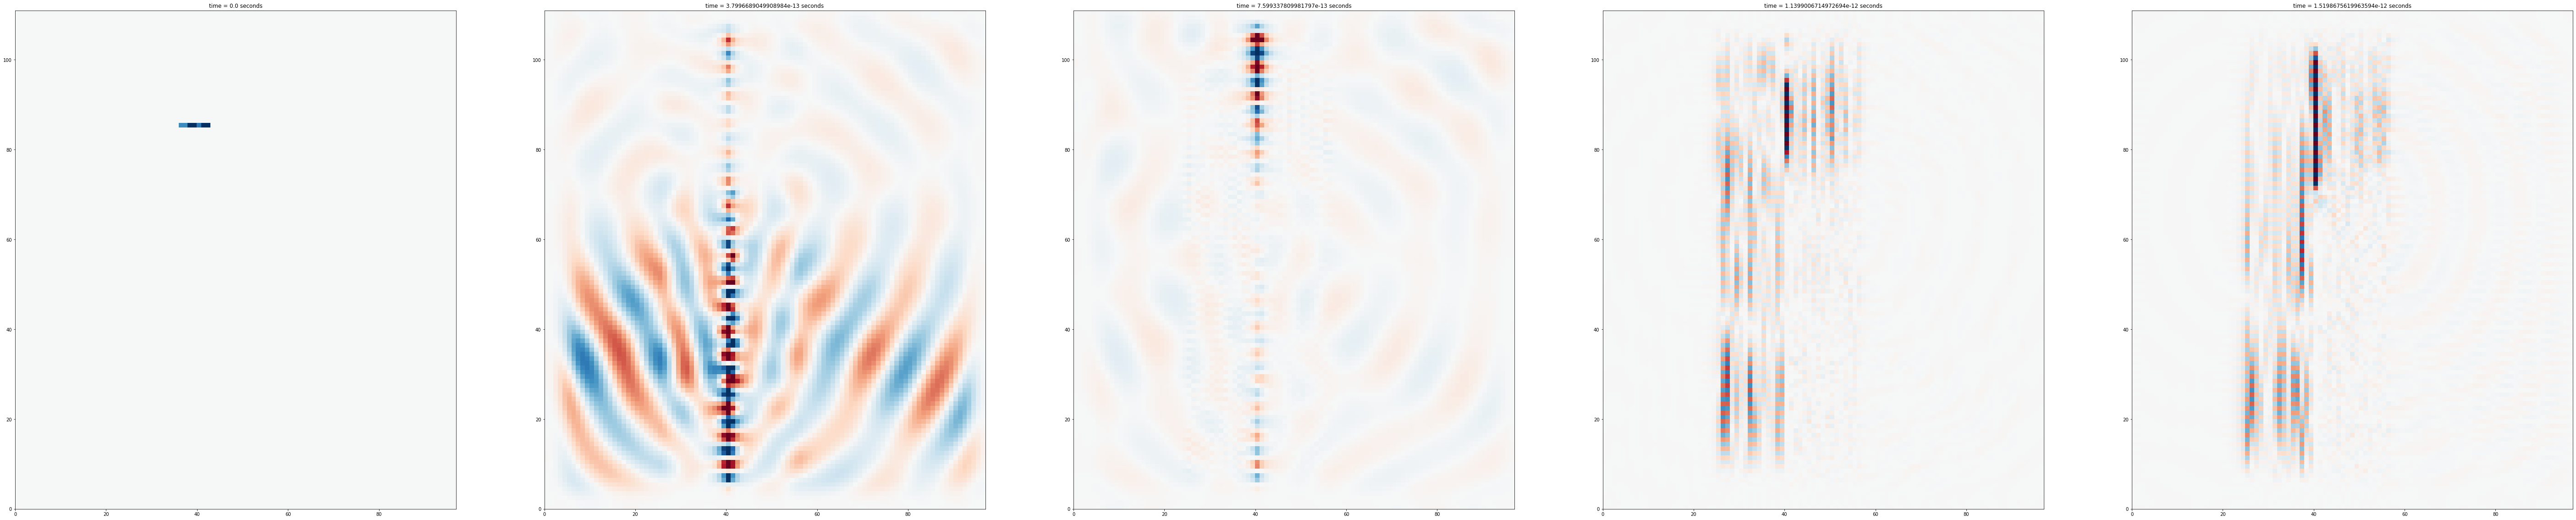

In [16]:
# `num_panels` field plots at even intervals, generated by FDTD
aniplot(F_t, source_fn, steps, component='Ez', num_panels=5)

### SPECTRAL POWER COMPUTATION

-> running FDTD within objective function
   - done with time step 0 of 19731 (0%)
   - done with time step 1000 of 19731 (5%)
   - done with time step 2000 of 19731 (10%)
   - done with time step 3000 of 19731 (15%)
   - done with time step 4000 of 19731 (20%)
   - done with time step 5000 of 19731 (25%)
   - done with time step 6000 of 19731 (30%)
   - done with time step 7000 of 19731 (35%)
   - done with time step 8000 of 19731 (40%)
   - done with time step 9000 of 19731 (45%)
   - done with time step 10000 of 19731 (50%)
   - done with time step 11000 of 19731 (55%)
   - done with time step 12000 of 19731 (60%)
   - done with time step 13000 of 19731 (65%)
   - done with time step 14000 of 19731 (70%)
   - done with time step 15000 of 19731 (76%)
   - done with time step 16000 of 19731 (81%)
   - done with time step 17000 of 19731 (86%)
   - done with time step 18000 of 19731 (91%)
   - done with time step 19000 of 19731 (96%)
-> computing FFT


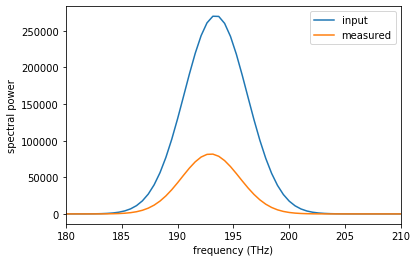

calculated a coupling efficiency of 27.787823567458304 %


In [17]:
#
# reshape other things for FDTD
eps_base = eps_base.reshape((Nx, Ny, 1))
teeth_density = teeth_density.reshape((Nx, Ny, 1))

def spectral_power(ff):
    """ This function computes the spectral power as a function of fill factor
        will autograd/differentiate this with FMD (cevijacobian function)
    """

    # setup FDTD using explicit projection into permittivity
    eps_teeth_proj = projection(teeth_density, (1 - ff), sub_eps, grating_eps)
    eps_total = eps_teeth_proj + eps_base
    F = fdtd(eps_total, dl, [npml, npml, 0])

    # compute fields at each time step at the source above
    # note: we're solving the reciprocal problem of a waveguide -> free space coupler
    measured = []
    print('-> running FDTD within objective function')
    for t_index in range(steps):
        if t_index % 1000 == 0:
            print('   - done with time step {} of {} ({}%)'.format(t_index, steps, int(t_index / steps * 100)))
        fields = F.forward(Jz=source_fn(t_index))
        measured.append(npa.sum(fields['Ez'] * source))

    # get spectral power through FFT
    print('-> computing FFT')
    measured_f = my_fft(npa.array(measured))
    spect_power = npa.square(npa.abs(measured_f)) / source_p
    return spect_power

# evaluate the function at `ff`
spect = spectral_power(ff)
T = spect / spect_in

n_disp = steps // 2  # number of time steps / frequency points to keep

# plot spectral power
if plot_all:
    fig, ax1 = plt.subplots()
    delta_f = 1 / steps / dt
    freq_x = np.arange(n_disp) * delta_f
    ax1.plot(freq_x / 1e12, spect_in[:n_disp], label='input')
    ax1.plot(freq_x / 1e12, spect[:n_disp], label='measured')
    ax1.set_ylabel('spectral power')
    ax1.set_xlabel('frequency (THz)')
    ax1.set_xlim((180, 210))
    ax1.legend()
    plt.show()

# total powers of the input and measured
P_in = np.sum(spect_in[:steps//4])
P_out = np.sum(spect[:steps//4])

# max power, for normalization
P_in_max = np.max(spect_in[:steps//4])

coupling_efficiency = P_out / P_in
print('calculated a coupling efficiency of {} %'.format(100 * coupling_efficiency))



### DIFFERENTIATION W.R.T. FILL FACTOR

In [18]:
# compute jacobians
print('-> FMD-ing')
jac_FMD = jacobian(spectral_power, mode='forward')(ff)
do_num_jac = False   # whether to compute numerical jacobian as well
if do_num_jac:
    jac_num = jacobian(spectral_power, mode='numerical')(ff)

delta_f = 1 / steps / dt              # frequency spacing in the FFT output
freq_x = np.arange(n_disp) * delta_f  # frequency range

-> FMD-ing
-> running FDTD within objective function
   - done with time step 0 of 19731 (0%)
   - done with time step 1000 of 19731 (5%)
   - done with time step 2000 of 19731 (10%)
   - done with time step 3000 of 19731 (15%)
   - done with time step 4000 of 19731 (20%)
   - done with time step 5000 of 19731 (25%)
   - done with time step 6000 of 19731 (30%)
   - done with time step 7000 of 19731 (35%)
   - done with time step 8000 of 19731 (40%)
   - done with time step 9000 of 19731 (45%)
   - done with time step 10000 of 19731 (50%)
   - done with time step 11000 of 19731 (55%)
   - done with time step 12000 of 19731 (60%)
   - done with time step 13000 of 19731 (65%)
   - done with time step 14000 of 19731 (70%)
   - done with time step 15000 of 19731 (76%)
   - done with time step 16000 of 19731 (81%)
   - done with time step 17000 of 19731 (86%)
   - done with time step 18000 of 19731 (91%)
   - done with time step 19000 of 19731 (96%)
-> computing FFT


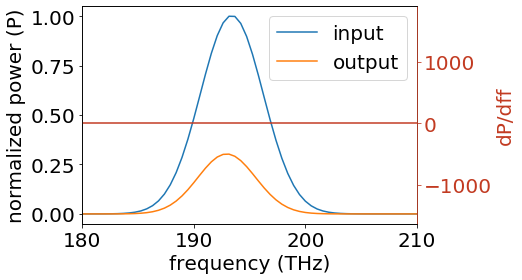

In [36]:
# plot derivatives along with spectral power
right_color = '#c23b22'
fig, ax1 = plt.subplots()
ax1.plot(freq_x / 1e12, spect_in[:n_disp] / P_in_max, label='input')
ax1.plot(freq_x / 1e12, spect[:n_disp] / P_in_max, label='output')
ax1.set_ylabel('normalized power (P)', color='k')
ax1.set_xlabel('frequency (THz)')
ax1.legend()
ax2 = ax1.twinx()
p2 = ax2.plot(freq_x / 1e12, jac_FMD[:n_disp, 0] / spect_in[:n_disp] / P_in_max, color=right_color, label='FMD')
if do_num_jac:
    ax2.plot(freq_x, jac_num[:n_disp, 0], 'bo', label='numerical')
    ax2.legend()
ax2.set_ylabel('dP/dff', color=right_color)
ax2.spines['right'].set_color(right_color)
ax2.tick_params(axis='y', colors=right_color)
ax1.set_xlim(left=180, right=210)
ax2.set_xlim(left=180, right=210)
plt.show()

No handles with labels found to put in legend.


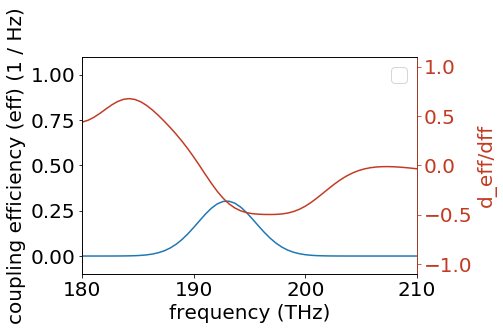

In [37]:
# efficiency version of above plot
right_color = '#c23b22'
fig, ax1 = plt.subplots()
ax1.plot(freq_x / 1e12, spect[:n_disp] / P_in_max)
ax1.set_ylabel('coupling efficiency (eff) (1 / Hz)', color='k')
ax1.set_xlabel('frequency (THz)')
ax1.legend()
ax2 = ax1.twinx()
p2 = ax2.plot(freq_x / 1e12, jac_FMD[:n_disp, 0] / spect_in[:n_disp], color=right_color, label='FMD')
if do_num_jac:
    ax2.plot(freq_x, jac_num[:n_disp, 0] / spect_in[:n_disp], 'bo', label='numerical')
    ax2.legend()
ax2.set_ylabel("d_eff/dff", color=right_color)
ax2.spines['right'].set_color(right_color)
ax2.tick_params(axis='y', colors=right_color)
ax1.set_xlim(left=180, right=210)
ax1.set_ylim(bottom=-0.1, top=1.1)
ax2.set_xlim(left=180, right=210)
ax2.set_ylim(bottom=-1.1, top=1.1)
plt.show()

### ALL THE PLOTS

In [23]:
# plot format and save settings
font = {'size': 20, 
        'weight' : 'normal'}

plt.rc('font', **font)

# where to store these plots
fname_base = './figs/tmp/'
print('-> saving plots to {}'.format(os.getcwd() + fname_base[1:]))

-> saving plots to /home/dodd/github/ceviche/examples/figs/tmp/


   - setup


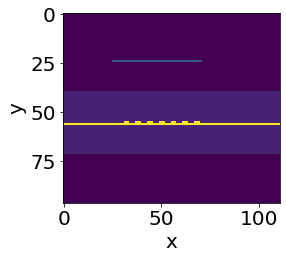

In [26]:
# setup
print('   - setup')
plt.imshow(np.real(imarr(eps_r + 3 * np.abs(source[:,:,0]))))
plt.xlabel('x'); plt.ylabel('y')
plt.tight_layout()
plt.savefig(fname_base + 'setup.pdf', dpi=400)

   - source


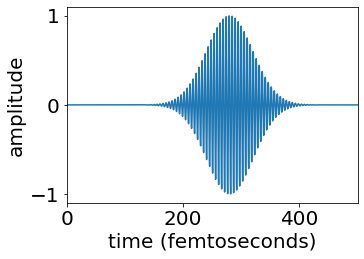

In [27]:
# source
print('   - source')
plt.plot(times * F_t.dt / 1e-15, gaussian(times))
plt.xlabel('time (femtoseconds)')
plt.ylabel('amplitude')
plt.xlim((0, 500))
plt.tight_layout()
plt.savefig(fname_base + 'pulse.pdf', dpi=400)

   - fields
-> re-solving FDFD for continuous epsilon


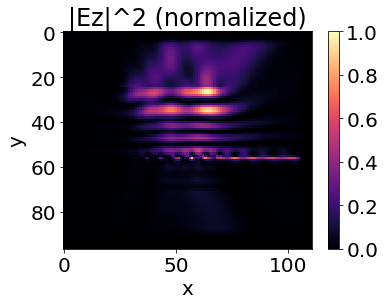

In [28]:
# FDFD fields
print('   - fields')
print('-> re-solving FDFD for continuous epsilon')
F = fdfd(omega0, dl, eps_total[:,:,0], NPML)
Hx, Hy, Ez = F.solve(source)
plt.tight_layout()
Ez2 = np.square(np.abs(imarr(Ez)))
plt.imshow(Ez2 / Ez2.max(), cmap='magma')
plt.title('|Ez|^2 (normalized)')
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar()
plt.savefig(fname_base + 'Ez2.pdf', dpi=400)

In [29]:
# left and right frequencies (THz)
left_f_P = 180; right_f_P = 210

   - spectral power


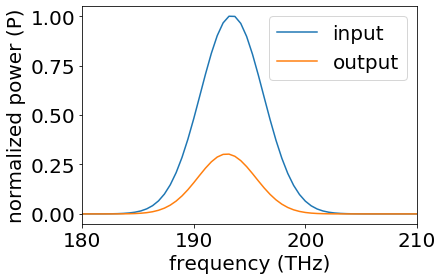

In [30]:
# spectral power
print('   - spectral power')
delta_f = 1 / steps / dt
freq_x = np.arange(n_disp) * delta_f
plt.tight_layout()
plt.plot(freq_x / 1e12, spect_in[:n_disp] / P_in_max, label='input')
plt.plot(freq_x / 1e12, spect[:n_disp] / P_in_max, label='output')
plt.ylabel('normalized power (P)', color='k')
plt.xlabel('frequency (THz)')
plt.xlim(left=left_f_P, right=right_f_P)
plt.legend()
plt.savefig(fname_base + 'powers.pdf', dpi=400)

   - power derivatives


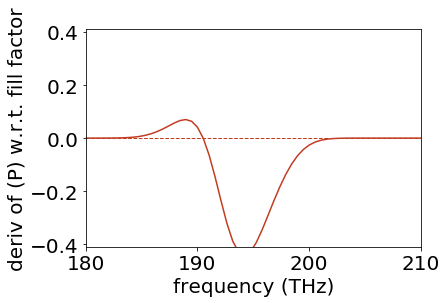

In [31]:
# power derivatives
print('   - power derivatives')
red = '#c23b22'
plt.plot(freq_x / 1e12, jac_FMD[:n_disp,0] / P_in_max, color=red, label='FMD')
plt.plot(freq_x / 1e12, np.zeros((n_disp, )), color=red, linestyle='dashed', linewidth=1)
plt.xlabel('frequency (THz)')
plt.ylabel('deriv of (P) w.r.t. fill factor')
plt.xlim(left=left_f_P, right=right_f_P)
plt.ylim(bottom=-.41, top=.41)
plt.savefig(fname_base + 'd_powers.pdf', dpi=400)

In [32]:
# left and right frequencies (THz)
left_f_n = 180; right_f_n = 210

   - spectral efficiencies


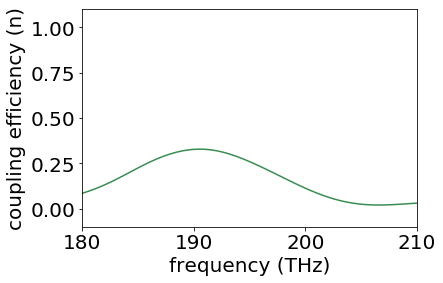

In [33]:
# spectral efficiencies
print('   - spectral efficiencies')
green = '#388c51'
plt.tight_layout()
plt.plot(freq_x / 1e12, spect[:n_disp] / spect_in[:n_disp], color=green)
plt.ylabel('coupling efficiency (n)')
plt.xlabel('frequency (THz)')
plt.xlim(left=left_f_n, right=right_f_n)
plt.ylim(bottom=-0.1, top=1.1)
plt.savefig(fname_base + 'efficiencies.pdf', dpi=400)

   - efficiency derivatives


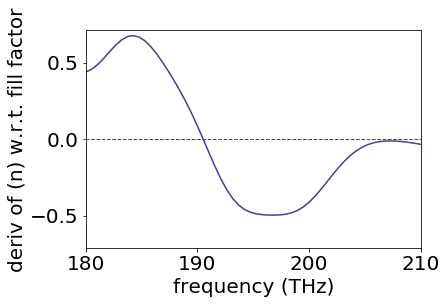

In [34]:
# efficiency derivatives
print('   - efficiency derivatives')
purple = '#51388c'
plt.plot(freq_x / 1e12, jac_FMD[:n_disp,0] / spect_in[:n_disp], color=purple, label='FMD')
plt.plot(freq_x / 1e12, np.zeros((n_disp,)), color=purple, linestyle='dashed', linewidth=1)
plt.xlabel('frequency (THz)')
plt.ylabel('deriv of (n) w.r.t. fill factor')
plt.xlim(left=left_f_n, right=right_f_n)
plt.ylim(bottom=-.71, top=.71)
plt.savefig(fname_base + 'd_efficiencies.pdf', dpi=400)

In [35]:
# save all of the parameters for reference
params = {
    'npml':npml,
    'dl':dl,
    'ff':ff,
    'lambda0':lambda0,
    'omega0':omega0,
    'k0':k0,
    'neff_teeth':neff_teeth,
    'neff_hole':neff_hole,
    'theta_deg':theta_deg,
    'theta':theta,
    'spc':spc,
    'h0':h0,
    'h1':h1,
    'subs':subs,
    'num_teeth':num_teeth,
    'sigma':sigma,
    'total_time':total_time,
    't0':t0,
    'sub_index':sub_index,
    'grating_index':grating_index,
    'sub_eps':sub_eps,
    'grating_eps':grating_eps,
    'coupling_efficiency':coupling_efficiency
}

with open(fname_base + 'params.json', 'w') as fp:
    json.dump(params, fp)
